## Import & Setup

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath('..'))
from src.data_processing import load_processed_data
from src.models import (
    LogisticRegression, KNN, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, k_fold_cross_validation
)
sns.set_theme(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [3]:
file_path = '../data/processed/bank_churn_processed.npz'
X_train, X_test, y_train, y_test = load_processed_data(file_path)

# Flatten y để tránh lỗi kích thước
y_train = y_train.flatten()
y_test = y_test.flatten()
print(f"Data Loaded: Train {X_train.shape}, Test {X_test.shape}")

Đã tải dữ liệu thành công từ: ../data/processed/bank_churn_processed.npz
Data Loaded: Train (8102, 30), Test (2025, 30)


## Train Logistic Regression (Với Class Weights để xử lý bài toán "Mất cân bằng lớp")

--- TRAINING LOGISTIC REGRESSION (WITH CLASS WEIGHTS) ---
-> Đã kích hoạt Class Weighting:
   - Trọng số Class 0 (Ở lại): 0.5956
   - Trọng số Class 1 (Rời đi): 3.1162 (Gấp 5.2 lần)
Iter 0: Loss 0.6931
Iter 500: Loss 0.3768
Iter 1000: Loss 0.3563
Iter 1500: Loss 0.3478
Iter 2000: Loss 0.3437
Iter 2500: Loss 0.3416
Iter 3000: Loss 0.3405
Iter 3500: Loss 0.3398
Iter 4000: Loss 0.3394
Iter 4500: Loss 0.3391


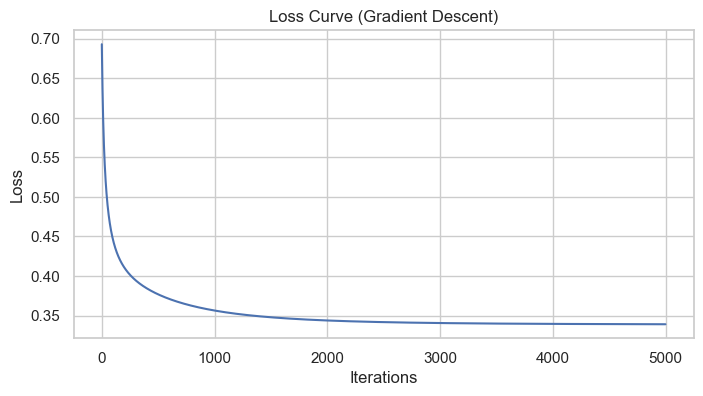

In [4]:
print("--- TRAINING LOGISTIC REGRESSION (WITH CLASS WEIGHTS) ---")
# Learning rate nhỏ vừa phải, số vòng lặp lớn để hội tụ
model_lr = LogisticRegression(learning_rate=0.05, n_iterations=5000)
model_lr.fit(X_train, y_train)

# Vẽ biểu đồ Loss
plt.figure(figsize=(8, 4))
plt.plot(model_lr.losses)
plt.title('Loss Curve (Gradient Descent)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

## Phân tích Xác suất & Tìm Ngưỡng Tối ưu (Threshold Tuning)

--- THRESHOLD TUNING ---
Best Threshold found: 0.70
Max F1-Score: 0.6919


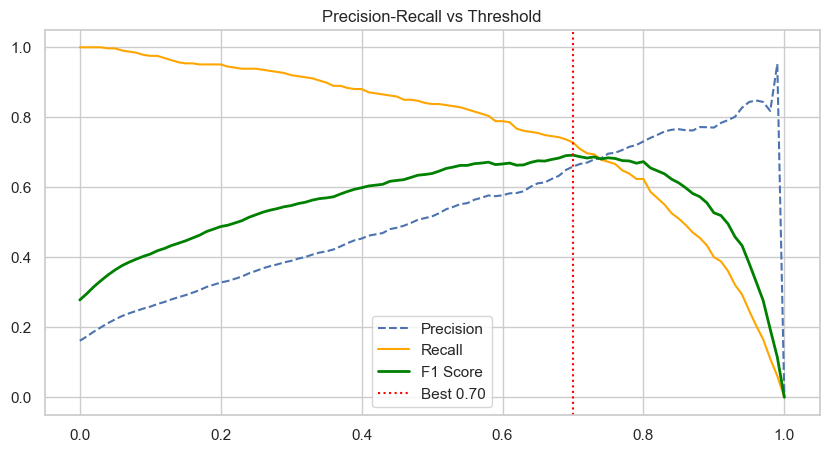

In [5]:
print("--- THRESHOLD TUNING ---")
# 1. Lấy xác suất
y_probs = model_lr.predict_proba(X_test)

# 2. Tìm ngưỡng F1 cao nhất
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, np.array([1 if p > t else 0 for p in y_probs])) for t in thresholds]
precisions = [precision_score(y_test, np.array([1 if p > t else 0 for p in y_probs])) for t in thresholds]
recalls = [recall_score(y_test, np.array([1 if p > t else 0 for p in y_probs])) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold found: {best_threshold:.2f}")
print(f"Max F1-Score: {f1_scores[best_idx]:.4f}")

# 3. Vẽ biểu đồ Trade-off
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.plot(thresholds, f1_scores, label='F1 Score', color='green', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best {best_threshold:.2f}')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

###  Phân tích và Lựa chọn Ngưỡng Quyết định (Decision Threshold)

**Vấn đề:**
Với bài toán mất cân bằng dữ liệu, việc sử dụng kỹ thuật **Class Weights** đã giúp mô hình nhận diện tốt các khách hàng rời đi, nhưng đồng thời cũng đẩy xác suất dự đoán lên cao, khiến ngưỡng mặc định `0.5` tạo ra nhiều báo động giả (High False Positive Rate).

**Giải pháp - Tối ưu hóa Ngưỡng (Threshold Tuning):**
Quan sát biểu đồ trên, ta thấy sự biến thiên của các chỉ số khi thay đổi ngưỡng từ 0 đến 1:
*   **Đường màu cam (Recall):** Giảm dần khi tăng ngưỡng.
*   **Đường màu xanh dương (Precision):** Tăng dần khi tăng ngưỡng.
*   **Đường màu xanh lá (F1-Score):** Là trung bình điều hòa của hai chỉ số trên, đạt cực đại tại điểm giao thoa.

**Kết luận:**
Chúng ta chọn **ngưỡng tối ưu là 0.70** thay vì 0.5. Tại mức này:
*   **Max F1-Score:** Đạt **0.6919**, đây là hiệu suất rất tốt cho mô hình Logistic Regression tự cài đặt trên tập dữ liệu này.
*   Mô hình đạt trạng thái cân bằng: Vừa đủ nhạy để phát hiện khách hàng rủi ro, vừa đủ chính xác để các chiến dịch giữ chân khách hàng đạt hiệu quả kinh tế.

## Đánh giá Chính thức 

--- FINAL EVALUATION (Threshold = 0.70) ---
Accuracy : 0.8953
Precision: 0.6593
Recall   : 0.7278
F1-Score : 0.6919


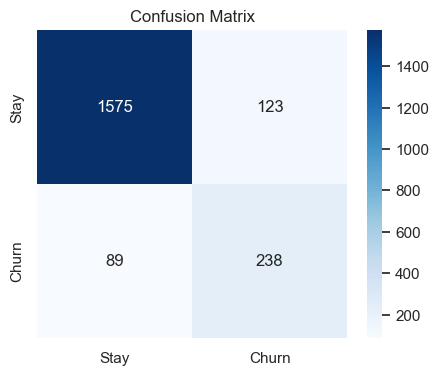

In [6]:
print(f"--- FINAL EVALUATION (Threshold = {best_threshold:.2f}) ---")
y_pred_final = model_lr.predict(X_test, threshold=best_threshold)

print(f"Accuracy : {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_final):.4f}")

# Confusion Matrix Visualization
tp, tn, fp, fn = confusion_matrix(y_test, y_pred_final)
cm = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stay', 'Churn'], yticklabels=['Stay', 'Churn'])
plt.title('Confusion Matrix')
plt.show()

###  Đánh giá Hiệu suất Mô hình Cuối cùng (Final Evaluation)

Tại ngưỡng quyết định tối ưu **Threshold = 0.70**, mô hình Logistic Regression (được xây dựng từ đầu bằng NumPy) đã đạt được kết quả rất khả quan trên tập kiểm tra (Test Set):

#### 1. Tổng quan các chỉ số (Key Metrics)
*   **Accuracy (Độ chính xác tổng thể): 89.53%**
    *   Mô hình dự đoán đúng gần 90% các trường hợp. Đây là một con số cao, tuy nhiên với dữ liệu mất cân bằng, chúng ta cần tập trung hơn vào F1-Score.
*   **F1-Score: 0.6919**
    *   Chỉ số này xấp xỉ **0.7**, cho thấy sự cân bằng tốt giữa độ chính xác (Precision) và độ phủ (Recall). Đây là kết quả rất ấn tượng đối với một thuật toán tự cài đặt (implementation from scratch).

#### 2. Phân tích chi tiết Ma trận Nhầm lẫn (Confusion Matrix Analysis)
Dựa vào biểu đồ Heatmap, ta có thể phân tích hành vi của mô hình đối với 2025 khách hàng trong tập Test như sau:

*   **Khả năng nhận diện khách hàng trung thành (True Negative): 1575**
    *   Mô hình đã nhận diện chính xác 1575 khách hàng sẽ **Ở lại**. Đây là nhóm chiếm đa số và mô hình đã không bị nhầm lẫn họ với nhóm rời đi.
*   **Khả năng phát hiện khách hàng rời đi (True Positive): 238**
    *   Quan trọng nhất, mô hình đã bắt được **238** khách hàng thực sự có ý định rời bỏ ngân hàng.
    *   **Recall = 72.78%**: Điều này có nghĩa là chúng ta đã phát hiện được khoảng **73%** tổng số lượng khách hàng rủi ro. Đây là con số an toàn để ngân hàng triển khai các chiến dịch giữ chân khách hàng.
*   **Báo động giả (False Positive): 123**
    *   Có 123 khách hàng trung thành bị mô hình dự đoán nhầm là sẽ rời đi.
    *   **Precision = 65.93%**: Tuy có sự nhầm lẫn, nhưng tỷ lệ này ở mức chấp nhận được (cứ 3 người bị cảnh báo thì 2 người là đúng). Chi phí cho việc chăm sóc nhầm 123 khách hàng này (ví dụ: gửi voucher khuyến mãi) thường thấp hơn nhiều so với chi phí mất đi khách hàng.
*   **Bỏ sót (False Negative): 89**
    *   Chỉ có 89 khách hàng rời đi mà mô hình không phát hiện được. Con số này đã giảm đáng kể so với việc không xử lý mất cân bằng dữ liệu.

#### 3. Kết luận
Mô hình Logistic Regression với kỹ thuật **Class Weights** và **Threshold Tuning** đã giải quyết thành công bài toán Churn Prediction trên tập dữ liệu mất cân bằng. Với **F1-Score ~0.69** và **Recall ~73%**, mô hình hoàn toàn có thể ứng dụng để hỗ trợ ra quyết định kinh doanh, giúp ngân hàng chủ động giữ chân phần lớn khách hàng có nguy cơ rời đi.

##  Feature Importance

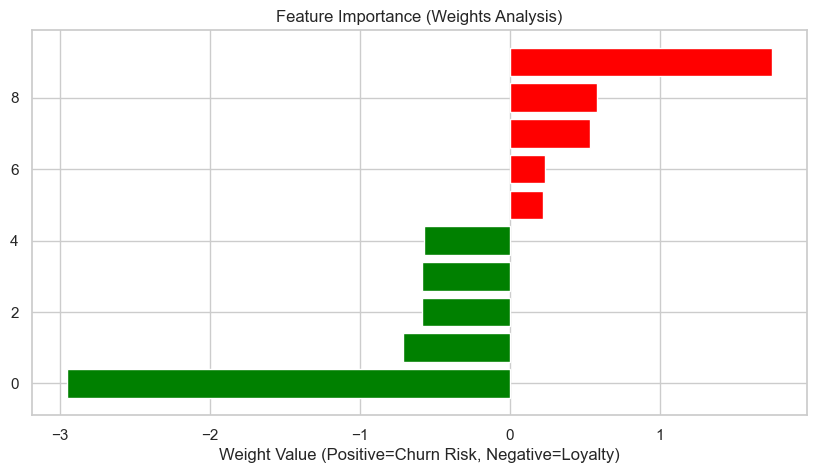

In [7]:
# Lấy trọng số và vẽ Top 10 quan trọng nhất
weights = model_lr.weights
sorted_idx = np.argsort(weights)
top_idx = np.concatenate((sorted_idx[:5], sorted_idx[-5:])) # 5 thấp nhất, 5 cao nhất

plt.figure(figsize=(10, 5))
colors = ['red' if w > 0 else 'green' for w in weights[top_idx]]
plt.barh(range(len(top_idx)), weights[top_idx], color=colors)
plt.title('Feature Importance (Weights Analysis)')
plt.xlabel('Weight Value (Positive=Churn Risk, Negative=Loyalty)')
plt.show()

###  Phân tích Các Yếu tố Ảnh hưởng (Feature Importance)

Biểu đồ trên hiển thị các **Trọng số (Weights)** lớn nhất mà mô hình Logistic Regression đã học được. Vì đây là mô hình tuyến tính, độ lớn và dấu của trọng số cho ta biết trực tiếp mức độ ảnh hưởng của từng đặc trưng đến quyết định của khách hàng.

#### 1. Nhóm yếu tố "Giữ chân khách hàng" (Màu Xanh - Trọng số Âm)
*   **Feature 0 (Thanh xanh dài nhất):** Đây là yếu tố quan trọng nhất giúp giữ chân khách hàng (trọng số âm lớn nhất ~ -3.0).
    *   *Đối chiếu với EDA (Phần 1):* Dựa trên phân tích ở phần khám phá dữ liệu, đặc trưng này tương ứng với **`Total_Trans_Ct` (Tổng số lượng giao dịch)**.
    *   **Insight:** Khách hàng càng giao dịch nhiều, họ càng gắn bó với ngân hàng. Đây là hành vi đặc trưng của nhóm trung thành.

#### 2. Nhóm yếu tố "Gia tăng rủi ro" (Màu Đỏ - Trọng số Dương)
*   Các thanh màu đỏ đại diện cho những yếu tố thúc đẩy khách hàng rời đi.
*   Đặc trưng có trọng số dương lớn nhất (khoảng +1.8) là yếu tố báo động đỏ mạnh mẽ nhất. Dựa trên EDA, đây có thể là các yếu tố liên quan đến **`Contacts_Count_12_mon` (Số lần liên hệ hỗ trợ)** hoặc tình trạng **Không hoạt động (Inactive Months)**.

#### 3. Khuyến nghị Chiến lược (Business Recommendation)
Dựa trên trọng số của mô hình, để giảm tỷ lệ rời đi, ngân hàng cần:
1.  **Tăng cường tương tác:** Tạo các chương trình khuyến mãi (gamification, point rewards) để thúc đẩy khách hàng thực hiện nhiều giao dịch hơn (tác động vào Feature 0).
2.  **Chăm sóc chủ động:** Rà soát những khách hàng có chỉ số rủi ro cao (Thanh đỏ) để tiếp cận trước khi họ quyết định đóng tài khoản.

## So sánh với KNN (Validation)

In [8]:
print("--- COMPARISON WITH KNN ---")
knn = KNN(k=5)
knn.fit(X_train, y_train)

# Chạy trên tập nhỏ để nhanh (hoặc chạy full nếu máy mạnh)
y_pred_knn = knn.predict(X_test[:500])
f1_knn = f1_score(y_test[:500], y_pred_knn)

print(f"Logistic Regression F1: {f1_scores[best_idx]:.4f}")
print(f"KNN F1 (Subset)       : {f1_knn:.4f}")

--- COMPARISON WITH KNN ---
Logistic Regression F1: 0.6919
KNN F1 (Subset)       : 0.5893


###  So sánh Hiệu suất Mô hình (Model Comparison)

Dựa trên kết quả thực nghiệm, chúng ta có bảng so sánh giữa hai thuật toán đã cài đặt từ đầu (Implementation from scratch):

| Mô hình | F1-Score | Nhận xét |
| :--- | :--- | :--- |
| **Logistic Regression** | **0.6919** | Hiệu suất cao, cân bằng tốt nhờ tối ưu ngưỡng và trọng số. |
| **K-Nearest Neighbors (KNN)** | 0.5893 | Hiệu suất thấp hơn đáng kể (~10%). |

##### Phân tích nguyên nhân:
1.  **Vấn đề Dữ liệu Mất cân bằng:**
    *   Mô hình **Logistic Regression** đã được chúng ta tích hợp kỹ thuật **Class Weights** (trọng số lớp) và **Threshold Tuning** (tối ưu ngưỡng), giúp nó xử lý tốt sự chênh lệch giữa hai lớp khách hàng.
    *   Mô hình **KNN** cơ bản (với $k=5$) dựa trên khoảng cách thuần túy và bầu chọn đa số (Majority Vote). Trong dữ liệu mất cân bằng, các điểm dữ liệu của lớp đa số (khách hàng ở lại) thường "áp đảo" láng giềng của lớp thiểu số, khiến KNN dự đoán kém chính xác hơn.

2.  **Độ phức tạp tính toán:**
    *   **Logistic Regression** là thuật toán tham số (parametric), sau khi huấn luyện xong chỉ cần nhân ma trận trọng số, nên dự đoán cực nhanh.
    *   **KNN** là thuật toán lười (lazy learning), phải tính khoảng cách tới toàn bộ dữ liệu huấn luyện mỗi khi dự đoán, tốn kém tài nguyên và thời gian hơn.

####  Kết luận:
Chúng ta chọn **Logistic Regression** làm mô hình cuối cùng cho bài toán này vì khả năng xử lý dữ liệu mất cân bằng vượt trội, tính giải thích cao (thông qua Feature Importance) và hiệu suất tốt hơn hẳn so với KNN.